# GRU

### read .csv file

In [1]:
import pandas as pd 
import numpy as np
dataset = pd.read_csv('NSRGY.csv')

### sort value according to date

In [2]:
dataset = dataset.sort_values('Date')

### check empty field

In [3]:
dataset.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Used for date

In [4]:
date_old = dataset['Date'].copy()
date_old = pd.to_datetime(date_old)
#view the data of the last 5 days
print(date_old.tail(5))

5194   2020-08-25
5195   2020-08-26
5196   2020-08-27
5197   2020-08-28
5198   2020-08-31
Name: Date, dtype: datetime64[ns]


In [5]:
from datetime import datetime
import datetime
lastDay = date_old.iloc[-1]
lastNext = lastDay + datetime.timedelta(days=1)
#print the next day that should be the first day of the predict 30 days
print(lastNext)

2020-09-01 00:00:00


### obtain the date of next 30 days

In [6]:
datelist = pd.date_range(lastNext, periods=30).tolist()
datelist = pd.to_datetime(datelist)
date_30 = datelist.copy()
date_30 = date_30.to_frame()
#print the first 5 days of the predicted 30 days
print(date_30.head(5))

                    0
2020-09-01 2020-09-01
2020-09-02 2020-09-02
2020-09-03 2020-09-03
2020-09-04 2020-09-04
2020-09-05 2020-09-05


### combine old date with new date

In [7]:
combined_date = pd.concat([date_old,date_30],ignore_index=True)
print(combined_date)

              0
0    2000-01-03
1    2000-01-04
2    2000-01-05
3    2000-01-06
4    2000-01-07
...         ...
5224 2020-09-26
5225 2020-09-27
5226 2020-09-28
5227 2020-09-29
5228 2020-09-30

[5229 rows x 1 columns]


### drop all column except 'Close'

In [8]:
close_all = dataset.loc[:, ['Close']].values
visual = dataset[['Date', 'Close']].copy()
visual['Date'] = pd.to_datetime(visual['Date'])
visual.set_index('Date', inplace=True)
print(close_all)

[[ 18.299999]
 [ 18.      ]
 [ 18.049999]
 ...
 [120.879997]
 [120.449997]
 [120.410004]]


### Visualisation

Text(0.5, 0.98, 'Original Data')

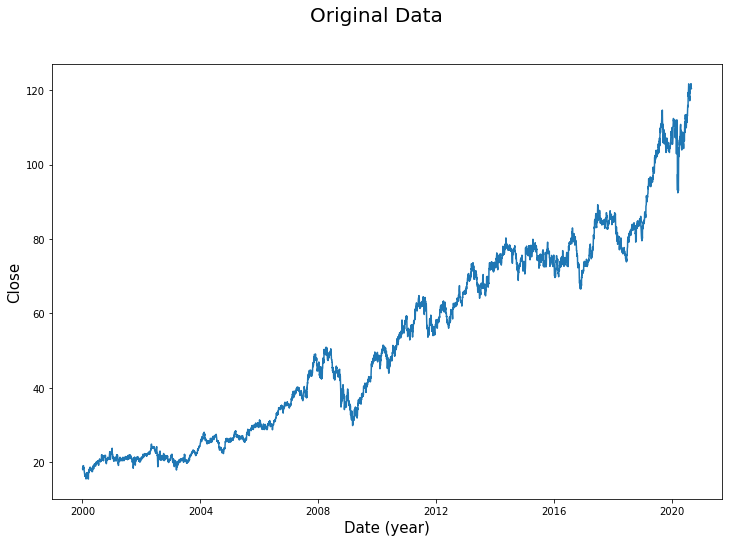

In [9]:
import numpy as np 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(visual)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Date (year)', fontsize=15)
plt.ylabel('Close', fontsize=15)
plt.suptitle('Original Data', fontsize=20)

### splitting dataset into front 80% for training and last 20% for testing

In [10]:
training_size=int(len(close_all)*0.8)
test_size=len(close_all)-training_size
train_data,test_data=close_all[0:training_size,:],close_all[training_size:len(close_all),:1]

In [11]:
training_size,test_size

(4159, 1040)

### Scale the training data within range of 0 to 1

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
train_data = scaler.fit_transform(train_data)
train_data

array([[0.04320986],
       [0.03858025],
       [0.03935183],
       ...,
       [0.973611  ],
       [0.9760802 ],
       [0.98317895]])

### set the time step to 100 for training set and testing set

In [13]:
time_step = 100
X_train_list, y_train_list = [], []
for i in range(len(train_data)-time_step-1):
    X_train_list.append(train_data[i:(i+time_step), 0])
    y_train_list.append(train_data[i + time_step, 0])
X_train, y_train = np.array(X_train_list),np.array(y_train_list)
print(X_train.shape)
print(y_train.shape)

(4058, 100)
(4058,)


### reshape the data to fit in GRU model

In [14]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
#X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### GRU modelling

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU

In [16]:
model=Sequential()
model.add(GRU(150,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(150,return_sequences=True))
model.add(GRU(150))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 150)          68850     
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 150)          135900    
_________________________________________________________________
gru_2 (GRU)                  (None, 150)               135900    
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 340,801
Trainable params: 340,801
Non-trainable params: 0
_________________________________________________________________


### fitting the training set into the model

In [18]:
model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
127/127 [==============================] - 19s 150ms/step - loss: 0.0058
Epoch 2/100
127/127 [==============================] - 20s 156ms/step - loss: 1.6595e-04
Epoch 3/100
127/127 [==============================] - 21s 169ms/step - loss: 1.5706e-04
Epoch 4/100
127/127 [==============================] - 21s 167ms/step - loss: 1.6851e-04
Epoch 5/100
127/127 [==============================] - 20s 160ms/step - loss: 1.5092e-04
Epoch 6/100
127/127 [==============================] - 20s 159ms/step - loss: 1.5817e-04
Epoch 7/100
127/127 [==============================] - 20s 159ms/step - loss: 1.2599e-04
Epoch 8/100
127/127 [==============================] - 21s 162ms/step - loss: 1.4603e-04
Epoch 9/100
127/127 [==============================] - 22s 171ms/step - loss: 1.2170e-04
Epoch 10/100
127/127 [==============================] - 22s 170ms/step - loss: 1.8232e-04
Epoch 11/100
127/127 [==============================] - 21s 168ms/step - loss: 1.4539e-04
Epoch 12/100
127/127 [=

127/127 [==============================] - 21s 162ms/step - loss: 1.0499e-04
Epoch 93/100
127/127 [==============================] - 20s 161ms/step - loss: 1.1575e-04
Epoch 94/100
127/127 [==============================] - 20s 160ms/step - loss: 1.1143e-04
Epoch 95/100
127/127 [==============================] - 20s 160ms/step - loss: 9.5069e-05
Epoch 96/100
127/127 [==============================] - 20s 161ms/step - loss: 1.0835e-04
Epoch 97/100
127/127 [==============================] - 20s 161ms/step - loss: 1.2033e-04
Epoch 98/100
127/127 [==============================] - 20s 160ms/step - loss: 1.0092e-04
Epoch 99/100
127/127 [==============================] - 20s 160ms/step - loss: 1.1083e-04
Epoch 100/100
127/127 [==============================] - 20s 160ms/step - loss: 9.4927e-05


### predict the training set

In [19]:
train_predict=model.predict(X_train)

### calculate the mean squared error between the actual result and predicted result

In [20]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.008919660220210774

### predict the testing set

In [21]:
test_data = scaler.transform(test_data)
test_data

array([[0.97716045],
       [0.98148141],
       [0.97499995],
       ...,
       [1.62623445],
       [1.61959864],
       [1.61898147]])

In [22]:
X_test_list, y_test_list = [], []
for i in range(len(test_data)-time_step-1):
    X_test_list.append(test_data[i:(i+time_step), 0])
    y_test_list.append(test_data[i + time_step, 0])
X_test, y_test = np.array(X_test_list),np.array(y_test_list)
print(X_test.shape)
print(y_test.shape)

(939, 100)
(939,)


In [23]:
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [24]:
test_predict=model.predict(X_test)

In [25]:
math.sqrt(mean_squared_error(y_test,test_predict))

0.020848885135921518

### Visualisation of result of training set and testing set

blue colour is original data

orange colour is predicted value using training data

green colour is predicted value using testing data

In [26]:
# visual is done at up. It shows all, so is equal to close_all
# scale back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
### Plotting 
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(close_all)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(close_all)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(close_all)-1, :] = test_predict

In [27]:
dt_train = pd.DataFrame(np.array(trainPredictPlot))
visual_train = pd.concat([date_old,dt_train], axis=1, ignore_index=True)
visual_train.set_index(visual_train.columns[0],inplace=True)

In [28]:
dt_test = pd.DataFrame(np.array(testPredictPlot))
visual_test = pd.concat([date_old,dt_test], axis=1, ignore_index=True)
visual_test.set_index(visual_test.columns[0],inplace=True)

Text(0.5, 0.98, 'Original, Train and Test Data')

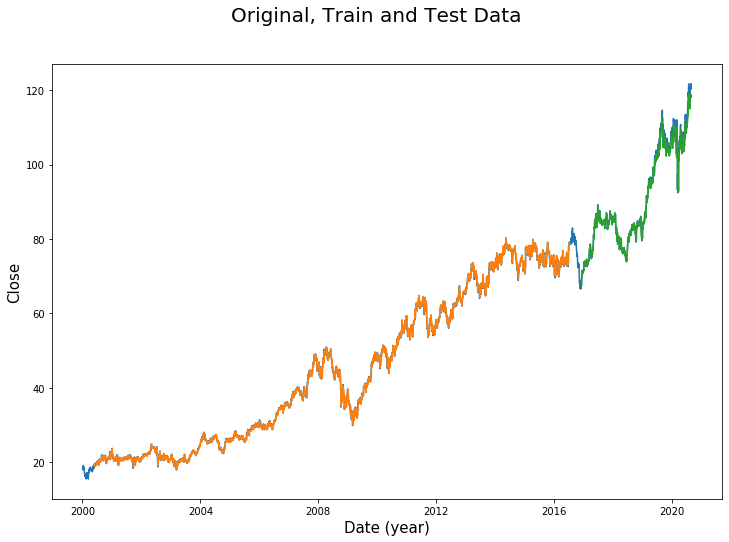

In [29]:
# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(visual)
plt.plot(visual_train)
plt.plot(visual_test)
#plt.show()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Date (year)', fontsize=15)
plt.ylabel('Close', fontsize=15)
plt.suptitle('Original, Train and Test Data', fontsize=20)

## Predict future 30 days

### get the last 100 day for time step of the future day

In [30]:
len(test_data)

1040

In [31]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
x_input.shape

(1, 100)

In [32]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[1.400771493791443,
 1.3929012009459318,
 1.4214505669081525,
 1.4158949961777005,
 1.434722171231998,
 1.4577159664637667,
 1.4708332343750044,
 1.4268517703618004,
 1.4458332972608041,
 1.3966048736139718,
 1.4462962447702354,
 1.4126542710190924,
 1.403703623285326,
 1.389043176433186,
 1.3827159545038907,
 1.371604828475085,
 1.3649690263131622,
 1.365277730002574,
 1.3850308000757343,
 1.4013887931455804,
 1.427469069715938,
 1.4390431432541753,
 1.4336419398005273,
 1.42206786626229,
 1.403703623285326,
 1.4077159996427775,
 1.4296295480109775,
 1.4169752430412694,
 1.4367282976823317,
 1.406327049089797,
 1.3932097966106574,
 1.3888888245884803,
 1.3708333007330262,
 1.3959875742598342,
 1.4279320172253696,
 1.437499964313273,
 1.4216049187528585,
 1.432870273169586,
 1.4143518172367984,
 1.4020060770676197,
 1.4395060907636068,
 1.4648147161351208,
 1.4807097616955356,
 1.438425843900038,
 1.4373455970364692,
 1.4586418614826298,
 1.4612653953117871,
 1.510648062778639,
 1.4922

### predict the future 30 days result

In [33]:
from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<30):
    
    if(len(temp_input)>time_step):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[1.5772578]
101
1 day input [1.3929012  1.42145057 1.415895   1.43472217 1.45771597 1.47083323
 1.42685177 1.4458333  1.39660487 1.44629624 1.41265427 1.40370362
 1.38904318 1.38271595 1.37160483 1.36496903 1.36527773 1.3850308
 1.40138879 1.42746907 1.43904314 1.43364194 1.42206787 1.40370362
 1.407716   1.42962955 1.41697524 1.4367283  1.40632705 1.3932098
 1.38888882 1.3708333  1.39598757 1.42793202 1.43749996 1.42160492
 1.43287027 1.41435182 1.40200608 1.43950609 1.46481472 1.48070976
 1.43842584 1.4373456  1.45864186 1.4612654  1.51064806 1.49228384
 1.49290113 1.49645056 1.48827157 1.46280859 1.47484561 1.46481472
 1.45679009 1.46512342 1.48209871 1.48425919 1.50030859 1.47916657
 1.49984564 1.49506161 1.51234561 1.50540121 1.52037025 1.53225303
 1.52978383 1.54922831 1.54907396 1.5435184  1.5819444  1.6030863
 1.58688267 1.6118826  1.62021594 1.63888877 1.62962952 1.5794752
 1.59722215 1.60231477 1.58564807 1.58719125 1.58904315 1.58641973
 1.56898138 1.60200607 1.60709868 1.60

13 day output [[1.3138534]]
14 day input [1.38271595 1.37160483 1.36496903 1.36527773 1.3850308  1.40138879
 1.42746907 1.43904314 1.43364194 1.42206787 1.40370362 1.407716
 1.42962955 1.41697524 1.4367283  1.40632705 1.3932098  1.38888882
 1.3708333  1.39598757 1.42793202 1.43749996 1.42160492 1.43287027
 1.41435182 1.40200608 1.43950609 1.46481472 1.48070976 1.43842584
 1.4373456  1.45864186 1.4612654  1.51064806 1.49228384 1.49290113
 1.49645056 1.48827157 1.46280859 1.47484561 1.46481472 1.45679009
 1.46512342 1.48209871 1.48425919 1.50030859 1.47916657 1.49984564
 1.49506161 1.51234561 1.50540121 1.52037025 1.53225303 1.52978383
 1.54922831 1.54907396 1.5435184  1.5819444  1.6030863  1.58688267
 1.6118826  1.62021594 1.63888877 1.62962952 1.5794752  1.59722215
 1.60231477 1.58564807 1.58719125 1.58904315 1.58641973 1.56898138
 1.60200607 1.60709868 1.60123452 1.62114195 1.62407397 1.62685175
 1.6276234  1.62669752 1.628858   1.62515421 1.63966042 1.62623445
 1.61959864 1.61898147 

 1.22584808 1.21926057 1.21296704 1.20694864]
27 day output [[1.2011876]]
28 day input [1.4367283  1.40632705 1.3932098  1.38888882 1.3708333  1.39598757
 1.42793202 1.43749996 1.42160492 1.43287027 1.41435182 1.40200608
 1.43950609 1.46481472 1.48070976 1.43842584 1.4373456  1.45864186
 1.4612654  1.51064806 1.49228384 1.49290113 1.49645056 1.48827157
 1.46280859 1.47484561 1.46481472 1.45679009 1.46512342 1.48209871
 1.48425919 1.50030859 1.47916657 1.49984564 1.49506161 1.51234561
 1.50540121 1.52037025 1.53225303 1.52978383 1.54922831 1.54907396
 1.5435184  1.5819444  1.6030863  1.58688267 1.6118826  1.62021594
 1.63888877 1.62962952 1.5794752  1.59722215 1.60231477 1.58564807
 1.58719125 1.58904315 1.58641973 1.56898138 1.60200607 1.60709868
 1.60123452 1.62114195 1.62407397 1.62685175 1.6276234  1.62669752
 1.628858   1.62515421 1.63966042 1.62623445 1.61959864 1.61898147
 1.57725775 1.54485238 1.51170826 1.48369122 1.45888293 1.4368186
 1.41687691 1.39866042 1.38188136 1.3663346

###  visualise the predicted result

In [34]:
day_new=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+31)

### before combine into original data

Text(0.5, 0.98, 'Previous N day List and Preticted 30 Days List')

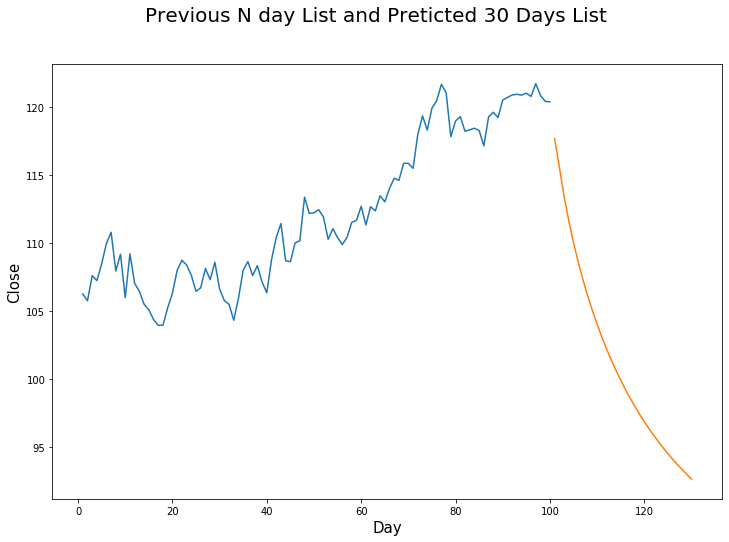

In [35]:
plt.figure(figsize=(12,8))
plt.plot(day_new,close_all[len(close_all)-time_step:])
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Close', fontsize=15)
plt.suptitle('Previous N day List and Preticted 30 Days List', fontsize=20)

### after combine into original data

Text(0.5, 0.98, 'Combined Previous N day and Preticted 30 Days')

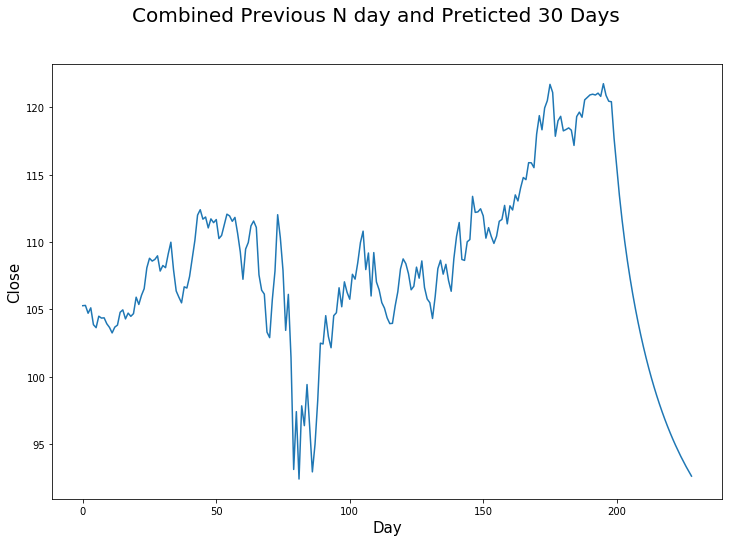

In [36]:
df=close_all.tolist()
df.extend(scaler.inverse_transform(lst_output))
plt.figure(figsize=(12,8))
plt.plot(df[5000:])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Close', fontsize=15)
plt.suptitle('Combined Previous N day and Preticted 30 Days', fontsize=20)

In [37]:
df=scaler.inverse_transform(df).tolist()

In [38]:
from pandas import DataFrame
df_data_all = DataFrame (df)
visual_add30 = pd.concat([combined_date,df_data_all], axis=1, ignore_index=True)
visual_add30.set_index(visual_add30.columns[0],inplace=True)
visual_add30.head(5)

,1
0,
2000-01-03,1201.339990
2000-01-04,1181.900054
2000-01-05,1185.139989
2000-01-06,1228.880056
2000-01-07,1243.460122


### all the data included predited 30 days

Text(0.5, 0.98, 'Combined with preticted 30 days')

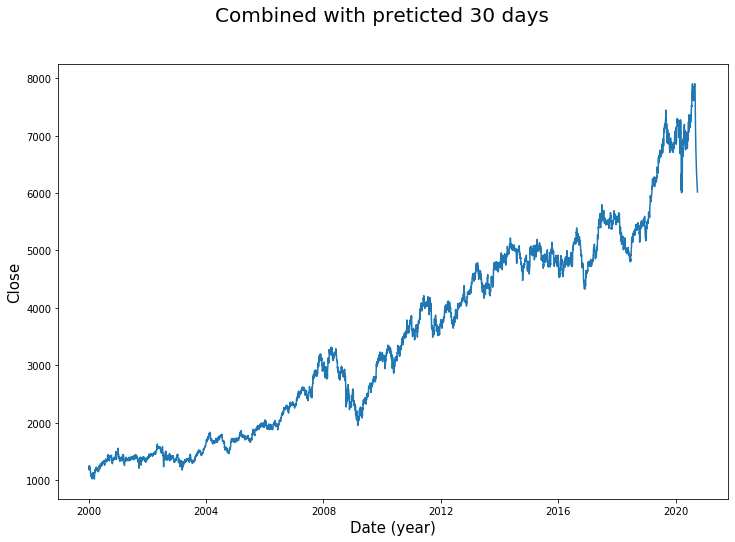

In [39]:
plt.figure(figsize=(12,8))
plt.plot(visual_add30)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Date (year)', fontsize=15)
plt.ylabel('Close', fontsize=15)
plt.suptitle('Combined with preticted 30 days', fontsize=20)